# Listeria Model Analyses

# Introduction
## Goal: 
Analyze the results from 7 models (KNN, SVM, GBM, RandomForest, Neural Network, Logistic Regression, Decision Tree) with different data inputs (standardized, original, and with/without cluster and logarithmic columns). Therefore, a grid search method was designed to use hyperparameters to optimize the models, and test on different data inputs.

## How to Run
Here is a ipynb file that can be run in an IDE or Google Colab for model testing and results. Please input the file name you would like to test, and the predictor column.

In this notebook, the exact same models that are provided on the competition, official git repo are used. The code is adapted to perform a grid search (search through a list of hyper parameters) to find the best model results.


## Analysis includes
- High level overview
- Accuracy plots
- Feature importance/column importance for models
- Precision/Recall Curves
- Test-Train Split Analysis


### To run the models and get results, run Run_and_Test_Models.ipynb


In [ ]:
# Importing necessary packages to run the models
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    PrecisionRecallDisplay
)
from keras.models import Sequential
from keras.layers import Dense, Input
import re
import json

# importing all the necessary packages for analysis
import matplotlib.pyplot as plt
import re
import json
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

# modeling for train-test curves
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


# Loading in the data

In [5]:
results_df = pd.read_csv(f"results_for_ListeriaSoil_clean_log.csv")

hyperparam_cols = [
    "logistic_reg_c", "lr_ratios",
    "nn_layers", "nn_neurons", "nn_batch_size", "nn_epochs",
    "dt_max_depth", "dt_min_samples_split",
    "svm_c_val", "svm_kernel",
    "knn_n_neighbor", "knn_metric",
    "gbm_learning_rate", "gbm_n_estimator",
    "rf_n_estimators", "rf_max_depth", "rf_min_samples_leaf"
]

# Base grouping keys
base_cols = ["model used", "scalar_status"]

# defining a hyperparameter combination
combo_cols = base_cols + hyperparam_cols

# main metric for analysis
primary_metric = 'accuracy'

## Helper functions for analyzing results

In [6]:
def parse_confusion_matrix(cm_str):
    """
    Parses strings like:
      '[[0 7]\n [0 8]]'
      '[[7 0]\n [8 0]]'
    Returns tn, fp, fn, tp as ints, or NaNs if missing.
    """
    if pd.isna(cm_str):
        return np.nan, np.nan, np.nan, np.nan

    s = str(cm_str).strip()

    # extract 4 integers in row-major order
    nums = re.findall(r"-?\d+", s)
    if len(nums) < 4:
        return np.nan, np.nan, np.nan, np.nan

    tn, fp, fn, tp = map(int, nums[:4])
    return tn, fp, fn, tp

def safe_div(a, b):
    return np.where(b == 0, np.nan, a / b)

In [7]:
def add_derived_columns(df):
    # Parse confusion matrix
    tn_fp_fn_tp = df["confusion matrix"].apply(parse_confusion_matrix)
    df[["tn", "fp", "fn", "tp"]] = pd.DataFrame(tn_fp_fn_tp.tolist(), index=df.index)

    # test n (prefer your stored test size; otherwise derive from cm)
    df["n_test_cm"] = df[["tn", "fp", "fn", "tp"]].sum(axis=1)
    df["n_test"] = df["n_test_cm"]

    # getting rate metrics
    df["tpr_recall"] = safe_div(df["tp"], (df["tp"] + df["fn"]))
    df["tnr_specificity"] = safe_div(df["tn"], (df["tn"] + df["fp"]))
    df["fpr"] = safe_div(df["fp"], (df["fp"] + df["tn"]))
    df["pred_pos_rate"] = safe_div((df["tp"] + df["fp"]), df["n_test"])
    df["prevalence"] = safe_div((df["tp"] + df["fn"]), df["n_test"])

    df["balanced_accuracy"] = 0.5 * (df["tpr_recall"] + df["tnr_specificity"])

    # Degenerate predictor flags
    df["degenerate_all_pos"] = (df["tn"] == 0) & (df["fn"] == 0) & df["n_test"].notna()
    df["degenerate_all_neg"] = (df["tp"] == 0) & (df["fp"] == 0) & df["n_test"].notna()

    # clean model name
    df["model used"] = df["model used"].astype(str).str.strip().str.lower()
    return df

# adding the parsed cols
results_df = add_derived_columns(results_df)

# High Level Statistics and Best Results

In [8]:
summary_stats = results_df.groupby(['model used', 'scalar_status'])[['accuracy', 'precision', 'recall', 'f1']].mean()
print("Summary Statistics of Performance Metrics for Each Model:")
print(summary_stats)

Summary Statistics of Performance Metrics for Each Model:
                                     accuracy  precision    recall        f1
model used          scalar_status                                           
decision_tree       orig             0.756569   0.831441  0.704605  0.762058
                    standard_scalar  0.754380   0.831873  0.699342  0.759108
gbm                 orig             0.847172   0.871269  0.851151  0.860954
                    standard_scalar  0.843978   0.867971  0.848684  0.858084
knn                 orig             0.694161   0.735700  0.700000  0.715185
                    standard_scalar  0.772993   0.785762  0.821053  0.799943
logistic regression orig             0.648175   0.715213  0.607895  0.657177
                    standard_scalar  0.821898   0.831023  0.852632  0.841609
neural net          orig             0.585341   0.661442  0.590844  0.578163
                    standard_scalar  0.755991   0.789014  0.761623  0.770380
random_forest     

In [ ]:
# container for the best probabilities
best_model_probabilities = {}

# ensuring the probabilty column exists
if 'y_pred_proba' not in results_df.columns:
    print("Error: 'y_pred_proba' column not found in results_df. Please re-run the models to generate probabilities.")
else:
    print(f"Extracting probabilities for best models based on {primary_metric}...")

    # identifying the best models
    # Grouping by model type and scalar status, then find the row with max primary_metric
    best_indices = results_df.groupby(['model used', 'scalar_status'])[primary_metric].idxmax()
    best_rows = results_df.loc[best_indices]

    for index, row in best_rows.iterrows():
        model_name = row['model used']
        scalar = row['scalar_status']
        score = row[primary_metric]

        # extract and parse probabilities
        prob_str = row.get('y_pred_proba')

        if pd.isna(prob_str):
            continue

        try:
            # if loaded from CSV, it's a string representation of a list
            if isinstance(prob_str, str):
                probs = json.loads(prob_str)
            else:
                # if the dataframe is fresh from memory, it might already be a list
                probs = prob_str

            key = f"{model_name} ({scalar})"
            best_model_probabilities[key] = probs
            print(f"Stored probs for {key:<30} (Score: {score:.4f})")

        except Exception as e:
            print(f"Error parsing probabilities for {model_name}: {e}")

Extracting probabilities for best models based on accuracy...
Stored probs for decision_tree (orig)           (Score: 0.8832)
Stored probs for decision_tree (standard_scalar) (Score: 0.8686)
Stored probs for gbm (orig)                     (Score: 0.9343)
Stored probs for gbm (standard_scalar)          (Score: 0.9416)
Stored probs for knn (orig)                     (Score: 0.8102)
Stored probs for knn (standard_scalar)          (Score: 0.8394)
Stored probs for logistic regression (orig)     (Score: 0.6569)
Stored probs for logistic regression (standard_scalar) (Score: 0.8467)
Stored probs for neural net (orig)              (Score: 0.7153)
Stored probs for neural net (standard_scalar)   (Score: 0.9051)
Stored probs for random_forest (orig)           (Score: 0.8613)
Stored probs for random_forest (standard_scalar) (Score: 0.8613)
Stored probs for svm (orig)                     (Score: 0.6277)
Stored probs for svm (standard_scalar)          (Score: 0.8905)


In [ ]:
# Best model for each type based on the primary metric
best_indices = results_df.groupby(['model used', 'scalar_status'])[primary_metric].idxmax()
best_models_df = results_df.loc[best_indices]

# selecting specific columns to display
cols_to_show = ['model used', 'scalar_status', 'accuracy', 'precision', 'recall', 'f1']
best_models_summary = best_models_df[cols_to_show].sort_values(by=primary_metric, ascending=False)

print(f"Performance metrics for the BEST model of each type (sorted by {primary_metric}):")
display(best_models_summary)

Performance metrics for the BEST model of each type (sorted by accuracy):


,model used,scalar_status,accuracy,precision,recall,f1
636,gbm,standard_scalar,0.941606,0.959459,0.934211,0.946667
645,gbm,orig,0.934307,0.946667,0.934211,0.940397
166,neural net,standard_scalar,0.905109,0.956522,0.868421,0.910345
617,svm,standard_scalar,0.890511,0.896104,0.907895,0.901961
547,decision_tree,orig,0.883212,0.905405,0.881579,0.893333
520,decision_tree,standard_scalar,0.868613,0.881579,0.881579,0.881579
588,random_forest,orig,0.861314,0.880000,0.868421,0.874172
561,random_forest,standard_scalar,0.861314,0.880000,0.868421,0.874172
4,logistic regression,standard_scalar,0.846715,0.857143,0.868421,0.862745
501,knn,standard_scalar,0.839416,0.875000,0.828947,0.851351


## Graphing Results

Text(0.5, 1.0, 'Degenerate check: predicted positive rate vs accuracy')

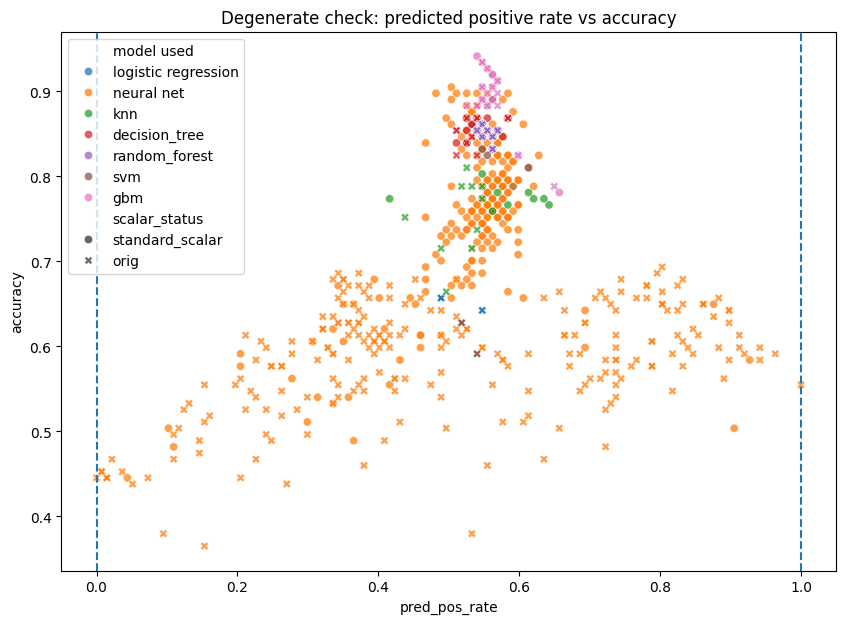

In [ ]:
tmp = results_df.dropna(subset=["pred_pos_rate", primary_metric]).copy()

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tmp,
    x="pred_pos_rate",
    y=primary_metric,
    hue="model used",
    style="scalar_status" if "scalar_status" in tmp.columns else None,
    alpha=0.75,
)
plt.axvline(0.0, linestyle="--")
plt.axvline(1.0, linestyle="--")
plt.title(f"Degenerate check: predicted positive rate vs {primary_metric}")

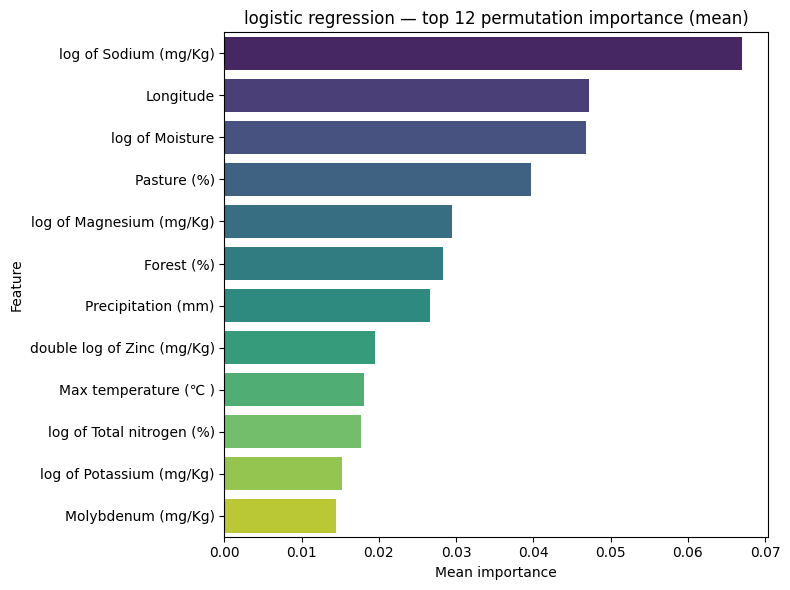

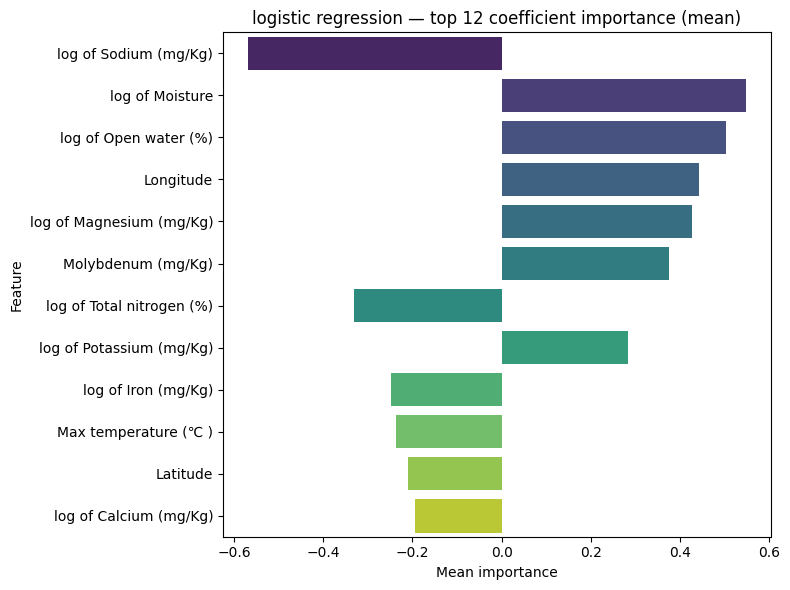

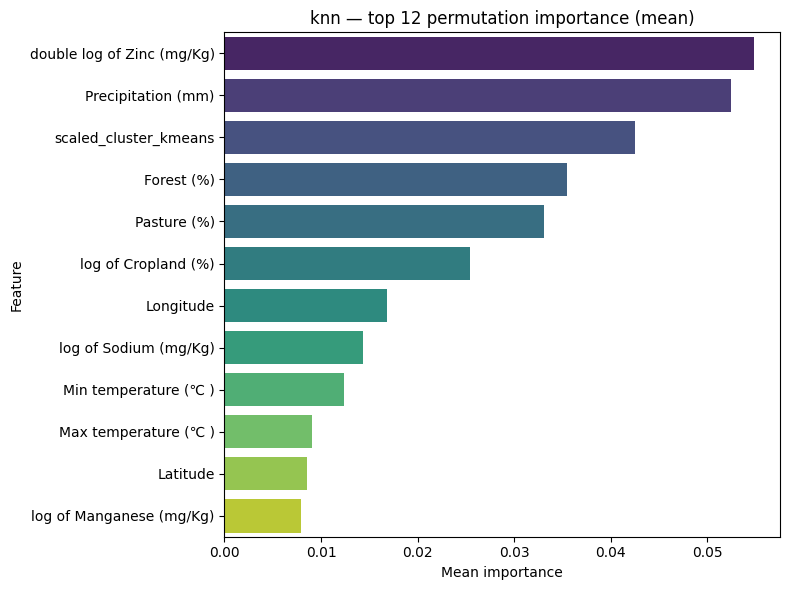

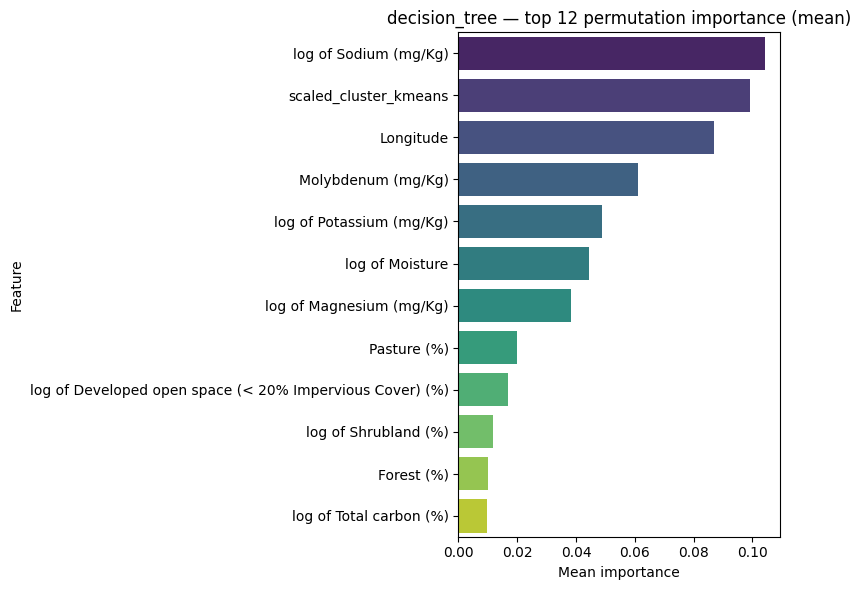

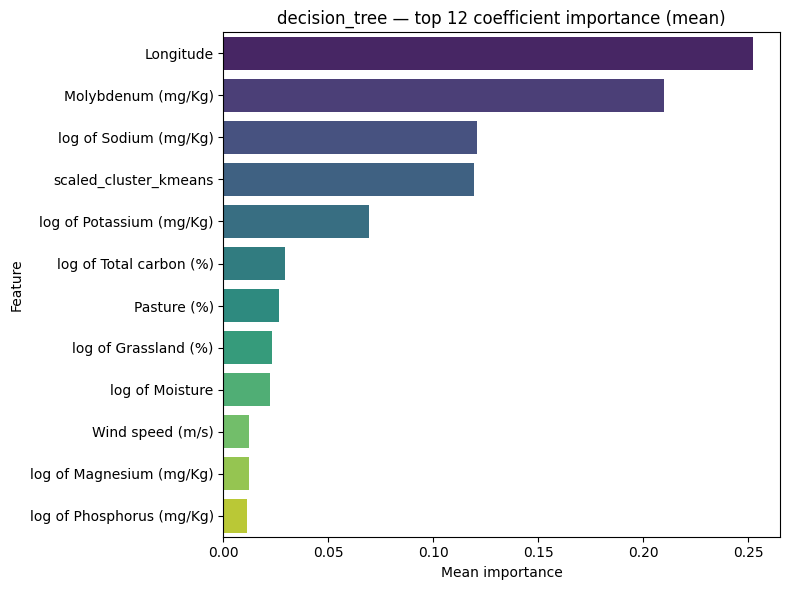

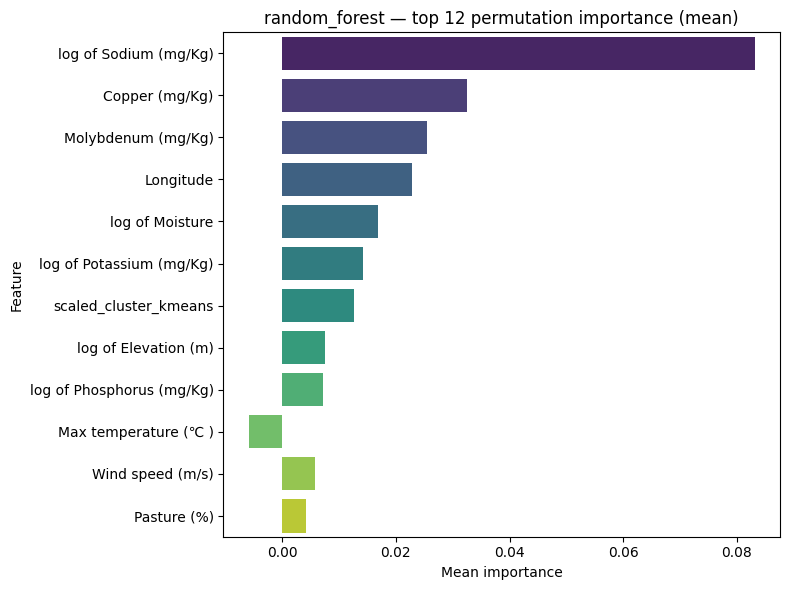

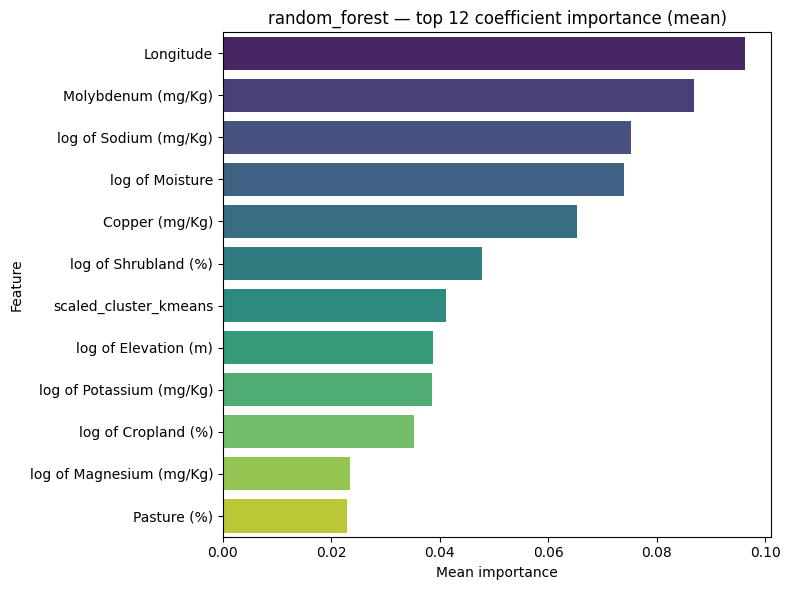

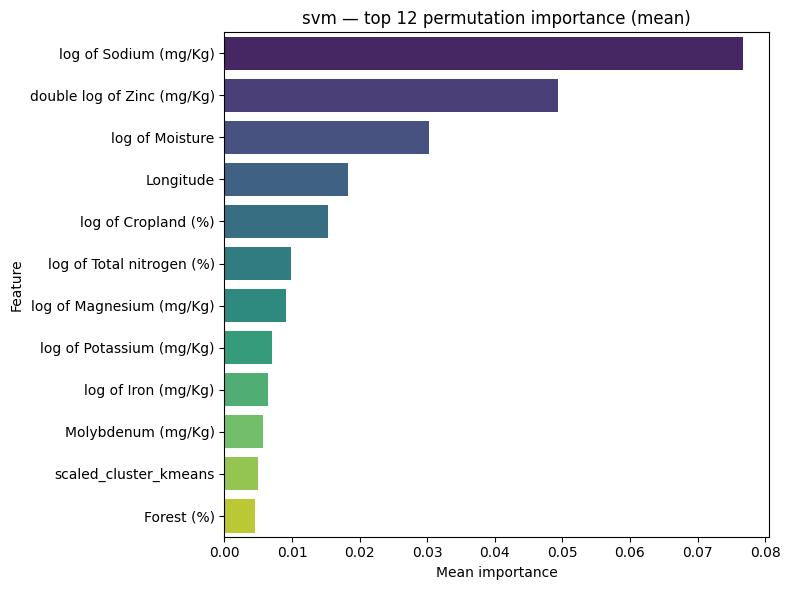

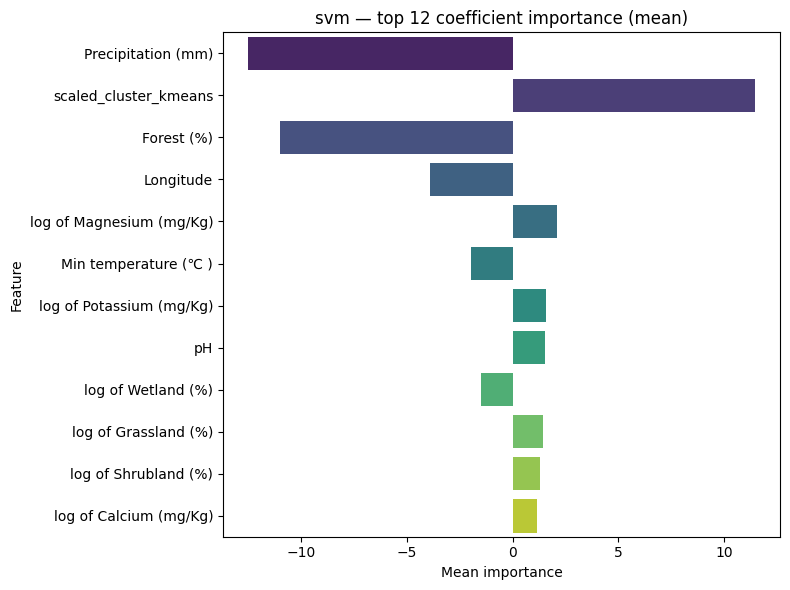

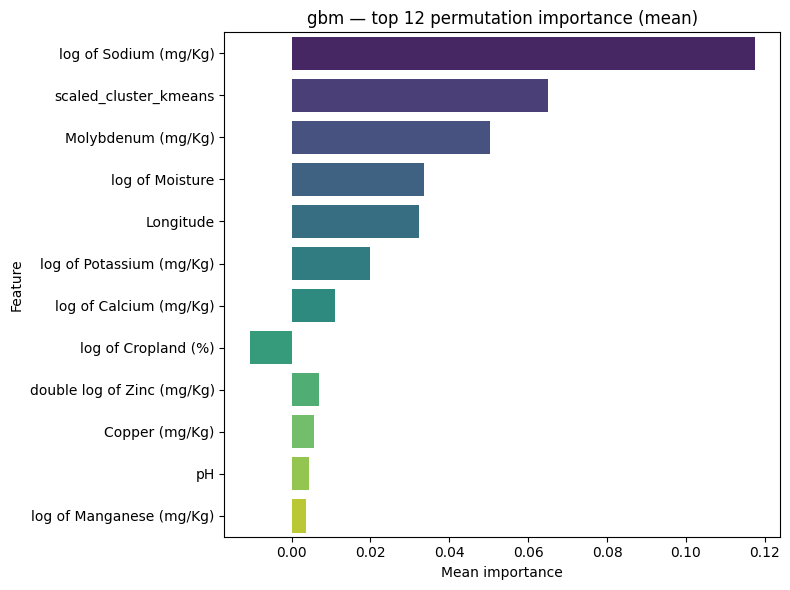

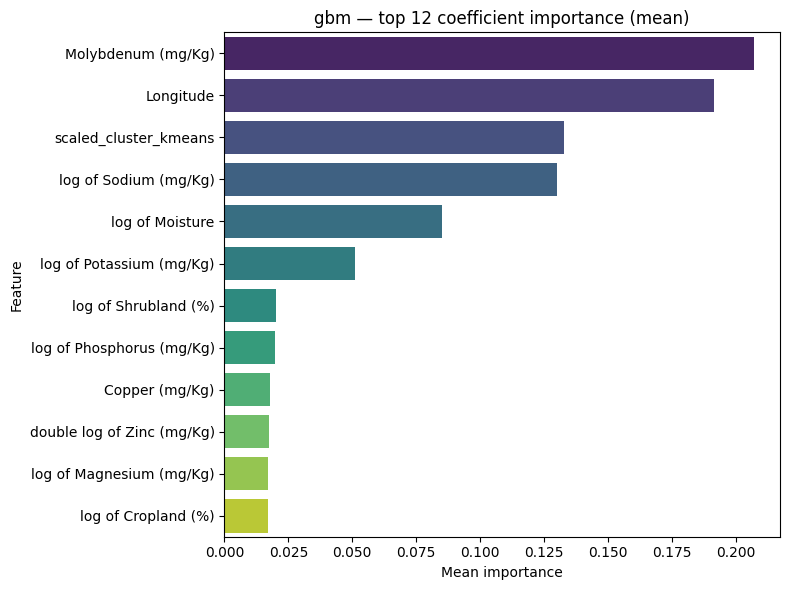

In [ ]:
def plot_feature_importances(df, model_name, importance_col='permutation_importance', top_n=12):
    """
    Aggregates and plots mean feature importance for a given model.
    importance_col: 'permutation_importance' or 'coefficient_importance'.
    """
    # filtering the DataFrame for the specific model and where the importance column is not NaN
    subset = df[(df['model used'] == model_name) & df[importance_col].notna()]
    # No data to plot if the subset is empty
    if subset.empty:
        return

    rows = []
    # iterating through each row in the filtered subset
    for _, row in subset.iterrows():
        # Parsing the importance string (which is JSON) into a dictionary
        try:
            val_str = row[importance_col]
            if pd.isna(val_str): continue
            imp_dict = json.loads(str(val_str))
        except Exception:
            continue
        # for each feature and its value in the importance dictionary
        for feat, val in imp_dict.items():
            # append a dictionary with the feature and its importance to the rows list
            rows.append({'feature': feat, 'importance': val})

    if not rows:
        return

    # creating a DataFrame from the extracted feature importances
    agg_df = pd.DataFrame(rows).groupby('feature')['importance'].mean()

    # sorting by absolute magnitude to capture strong negative coefficients
    agg_df_abs = agg_df.abs().sort_values(ascending=False).head(top_n)

    # selecting the original values for those top N features (to show sign)
    imp_df = agg_df.loc[agg_df_abs.index]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=imp_df.values, y=imp_df.index, hue=imp_df.index, palette='viridis', legend=False)
    plt.title(f"{model_name} — top {top_n} {importance_col.replace('_', ' ')} (mean)")
    plt.xlabel('Mean importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# gernerating plots for each model present in the results_df
models = results_df['model used'].dropna().unique() if 'model used' in results_df.columns else []
for m in models:
    # If 'permutation_importance' column exists, plot permutation importances
    if 'permutation_importance' in results_df.columns:
        plot_feature_importances(results_df, m, 'permutation_importance', top_n=12)
    # If 'coefficient_importance' column exists, plot coefficient importances
    if 'coefficient_importance' in results_df.columns:
        plot_feature_importances(results_df, m, 'coefficient_importance', top_n=12)

## AUC and Precision-Recall Curves

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:255: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower left")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:255: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower left")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:255: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower left")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_plot/precision_recall_curve.py:255: UserWarnin

PR Curve - decision_tree (orig)
Best accuracy: 0.8832
MaxDepth=200.0 MinSplit=10 - AUC: 0.8930

PR Curve - decision_tree (standard_scalar)
Best accuracy: 0.8686
MaxDepth=50.0 MinSplit=2 - AUC: 0.8670

PR Curve - gbm (orig)
Best accuracy: 0.9343
LR=0.05 N_Estimators=800 - AUC: 0.9748

PR Curve - gbm (standard_scalar)
Best accuracy: 0.9416
LR=0.20 N_Estimators=400 - AUC: 0.9739

PR Curve - knn (orig)
Best accuracy: 0.8102
Neighbors=10 Weights=distance - AUC: 0.8890

PR Curve - knn (standard_scalar)
Best accuracy: 0.8394
Neighbors=2 Weights=distance - AUC: 0.8829

PR Curve - logistic regression (orig)
Best accuracy: 0.6569
C=0.01 L1_ratio=0.00 - AUC: 0.6907

PR Curve - logistic regression (standard_scalar)
Best accuracy: 0.8467
C=1.00 L1_ratio=0.00 - AUC: 0.9055

PR Curve - neural net (orig)
Best accuracy: 0.7153
Layers=3 Neurons=32 Batch=32 Epochs=10 - AUC: 0.7490

PR Curve - neural net (standard_scalar)
Best accuracy: 0.9051
Layers=3 Neurons=64 Batch=32 Epochs=20 - AUC: 0.9374

PR Curve

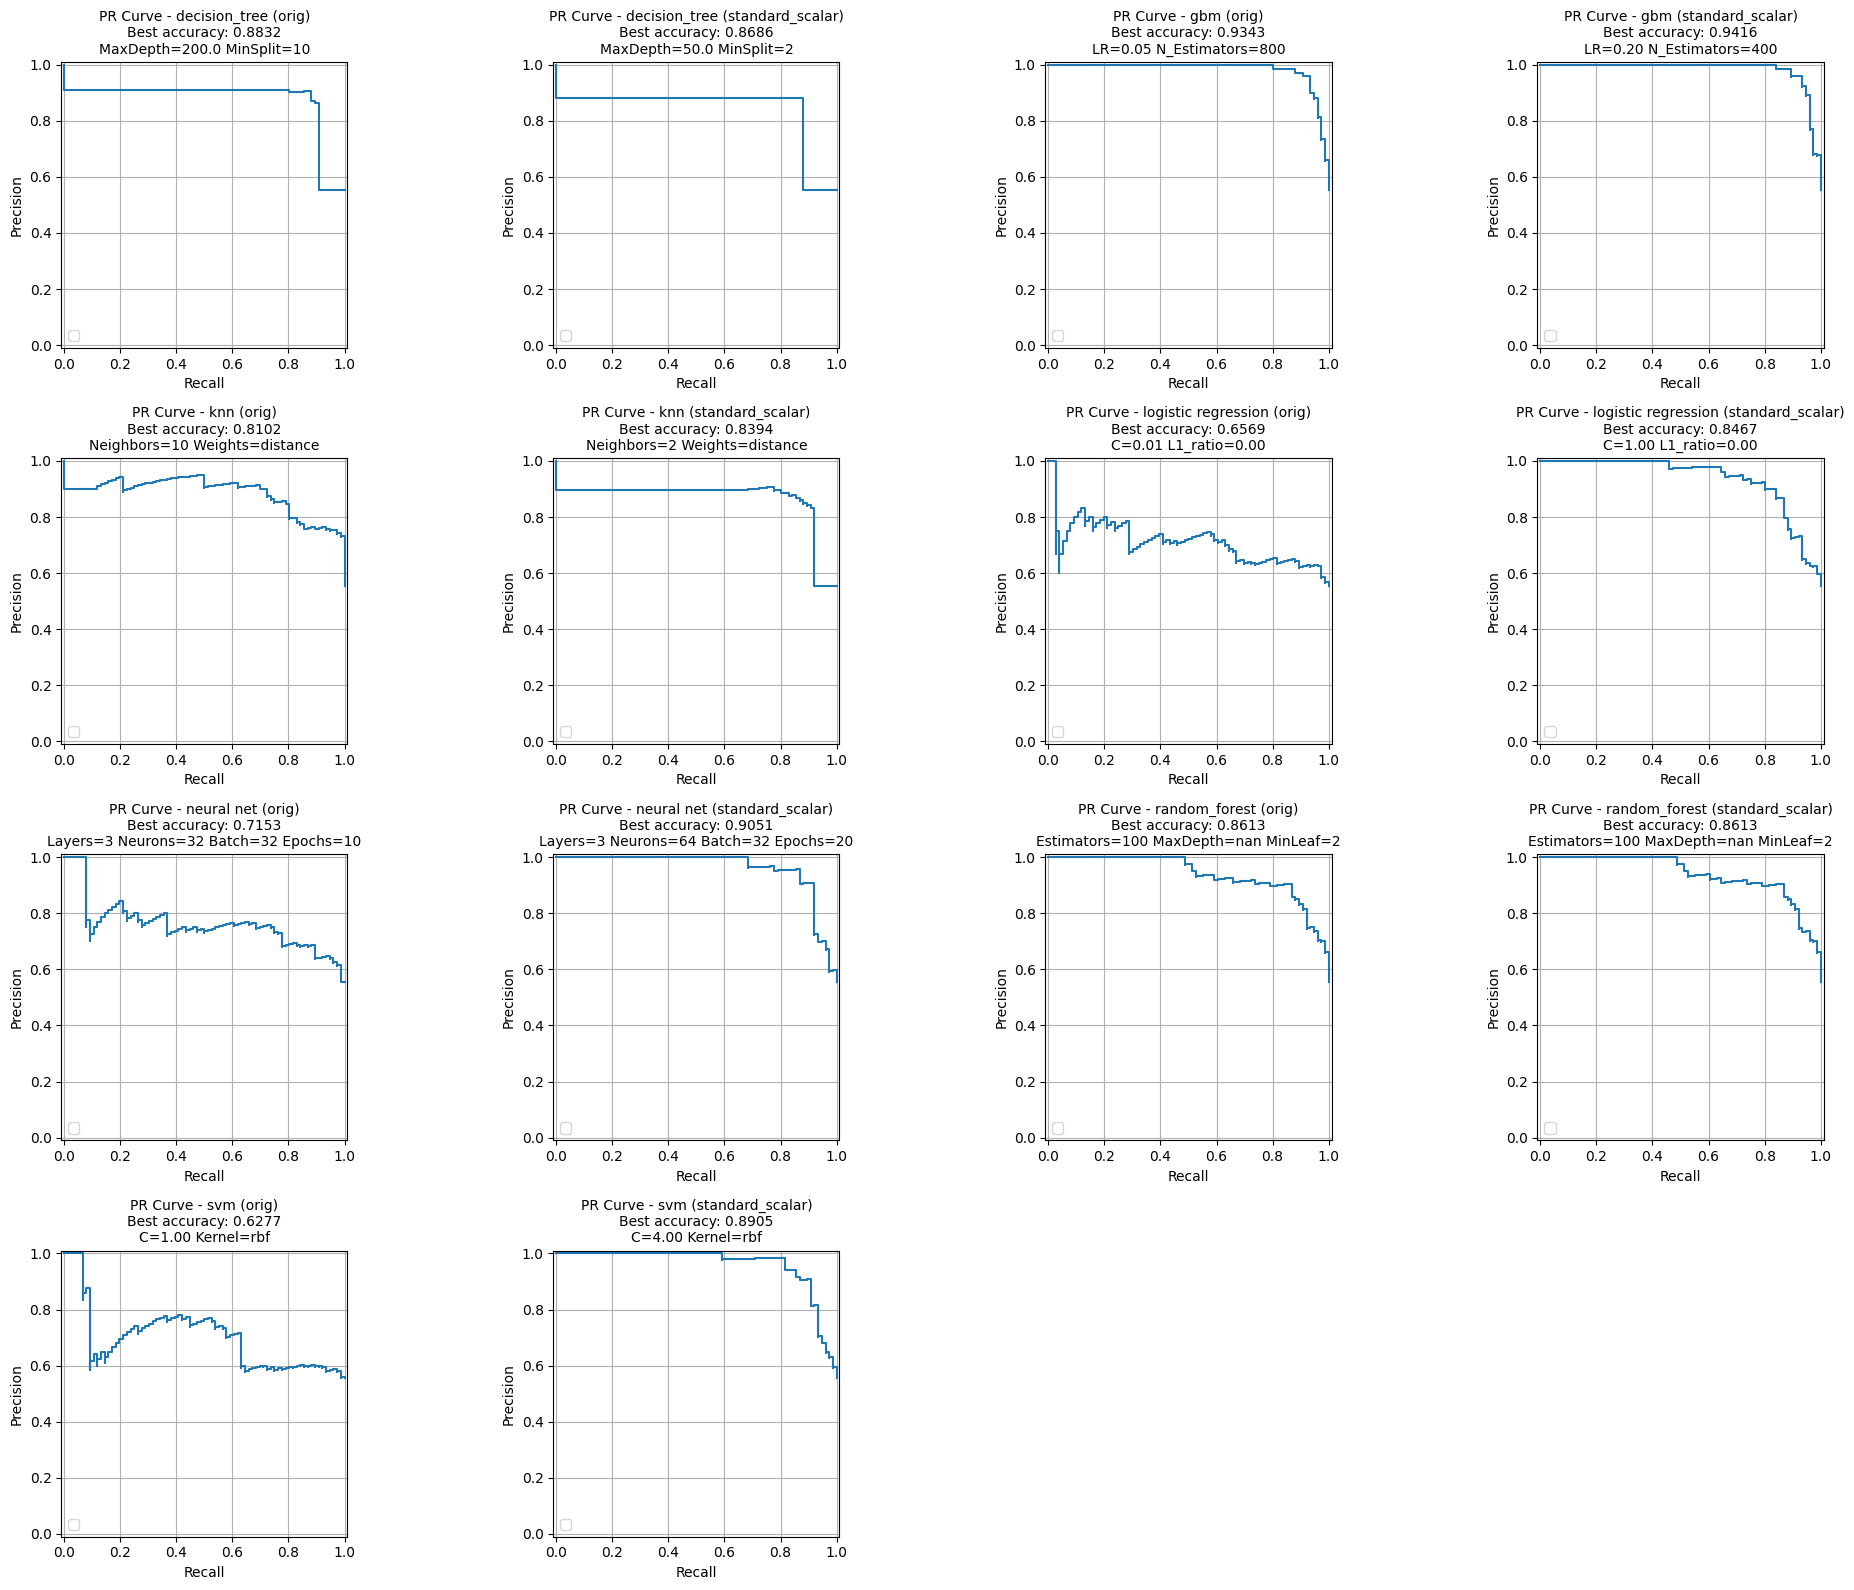

In [ ]:
# helper function to plot PR curve on a given axis
def plot_pr_curve_on_ax(y_test, y_pred_proba, title, ax):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name="").plot(ax=ax)
    ax.set_title(title, fontsize=10)
    ax.grid(True)

# finding the best model for each type based on primary_metric
best_models = results_df.loc[results_df.groupby(['model used', 'scalar_status'])[primary_metric].idxmax()]

# preparing for subplots
num_plots = len(best_models)
if num_plots == 0:
    print("No best models found to plot PR curves.")
else:
    # calculating grid dimensions for subplots
    num_cols = int(np.ceil(np.sqrt(num_plots))) # Try for a square layout
    num_rows = int(np.ceil(num_plots / num_cols))

    # creating figure and a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
    axes = axes.flatten() if num_plots > 1 else [axes]

    plot_idx = 0
    # loop through each stored prediction and plot PR curve
    for _, row in best_models.iterrows():
        model_name = row['model used']
        scalar_status = row['scalar_status']
        y_test = np.array(json.loads(row['y_test']))
        y_pred_proba = np.array(json.loads(row['y_pred_proba']))
        title = f"""PR Curve - {model_name} ({scalar_status})
Best {primary_metric}: {row[primary_metric]:.4f}"""

        # adding hyperparameters to the title
        if model_name == "logistic regression":
            title += f"\nC={row['logistic_reg_c']:.2f} L1_ratio={row['lr_ratios']:.2f}"
        elif model_name == "neural net":
            title += f"\nLayers={int(row['nn_layers'])} Neurons={int(row['nn_neurons'])} Batch={int(row['nn_batch_size'])} Epochs={int(row['nn_epochs'])}"
        elif model_name == "knn":
            title += f"\nNeighbors={int(row['knn_n_neighbor'])} Weights={row['knn_weights']}"
        elif model_name == "decision_tree":
            title += f"\nMaxDepth={row['dt_max_depth']} MinSplit={int(row['dt_min_samples_split'])}"
        elif model_name == "random_forest":
            title += f"\nEstimators={int(row['rf_n_estimators'])} MaxDepth={row['rf_max_depth']} MinLeaf={int(row['rf_min_samples_leaf'])}"
        elif model_name == "svm":
            title += f"\nC={row['svm_c_val']:.2f} Kernel={row['svm_kernel']}"
        elif model_name == "gbm":
            title += f"\nLR={row['gbm_learning_rate']:.2f} N_Estimators={int(row['gbm_n_estimator'])}"

        plot_pr_curve_on_ax(y_test, y_pred_proba, title, axes[plot_idx])

        # calculate and print AUC
        auc_score = roc_auc_score(y_test, y_pred_proba)
        print(f"{title} - AUC: {auc_score:.4f}\n")

        plot_idx += 1

    # hiding any unused subplots
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

## Test-train Validation Curves

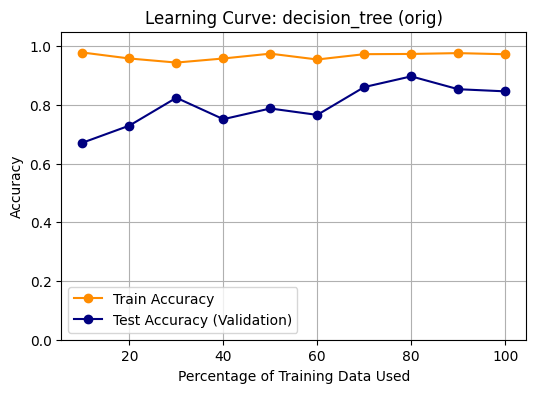

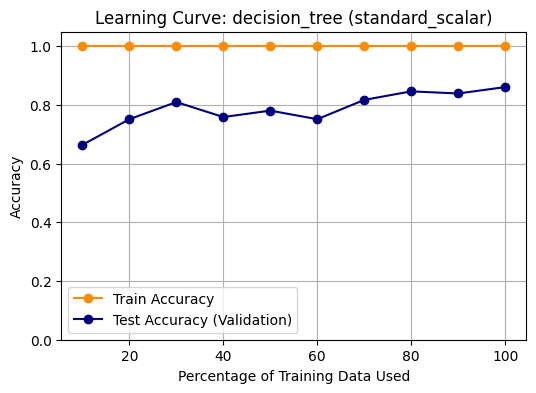

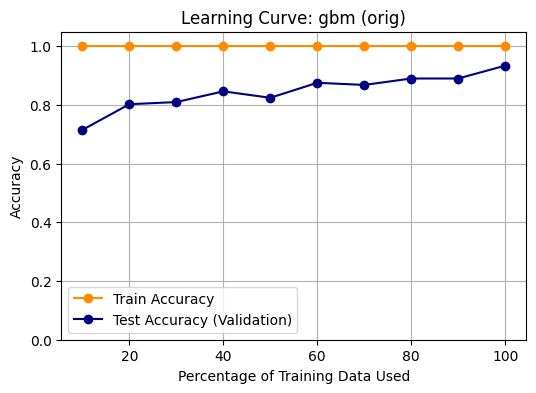

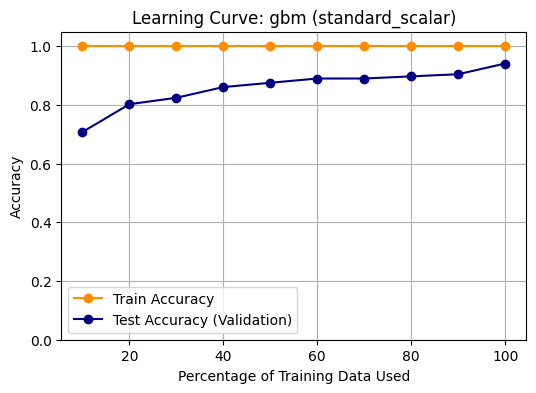

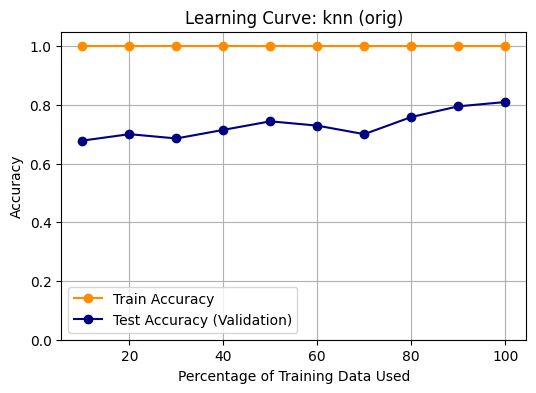

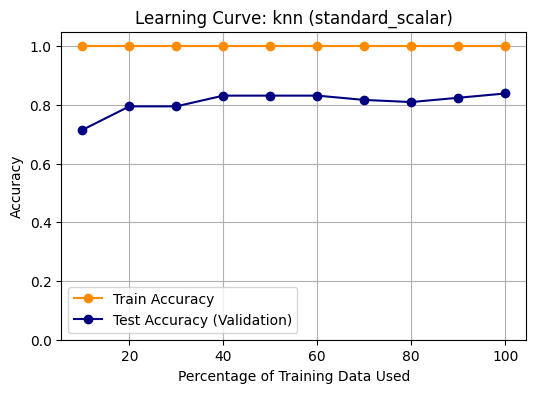

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed

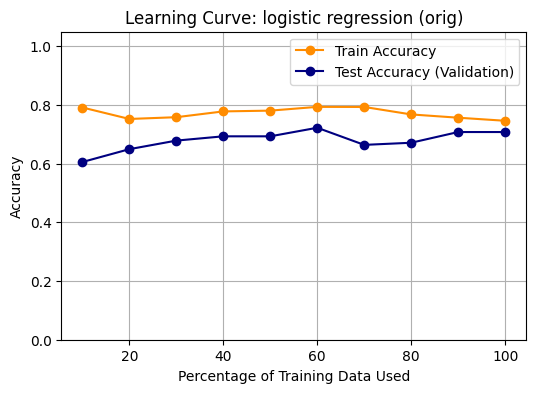

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_

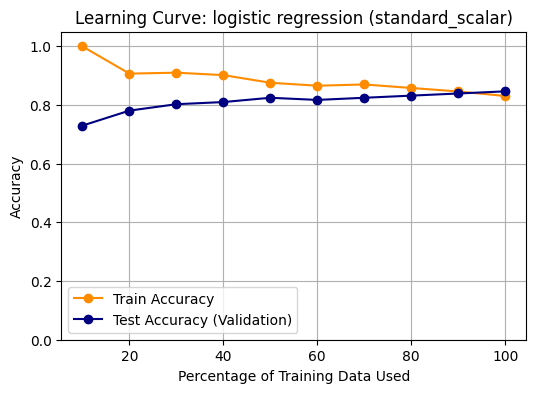

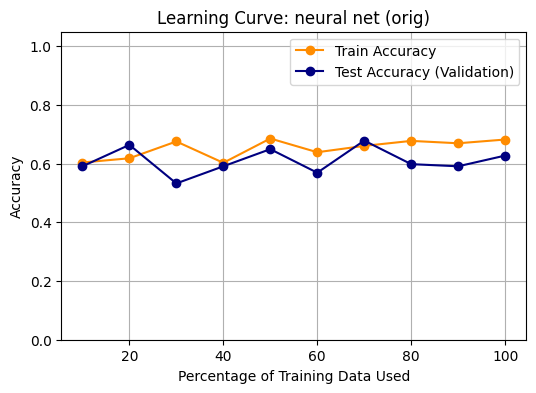

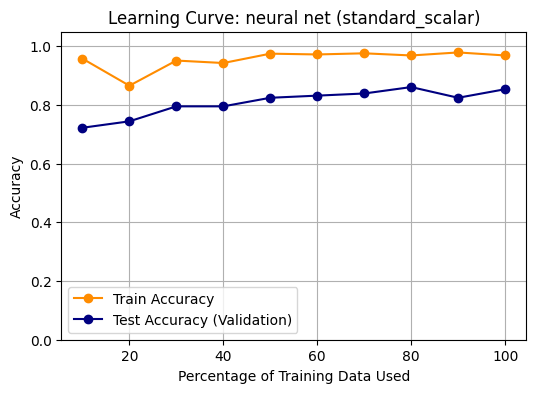

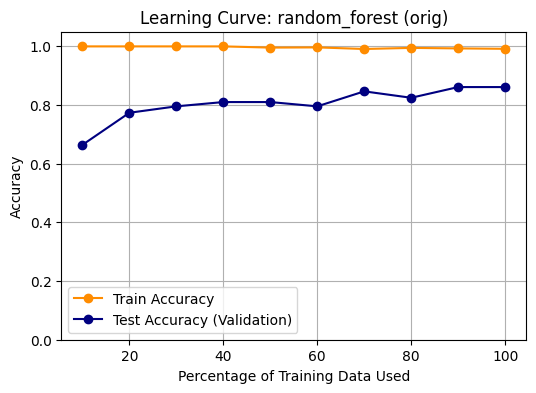

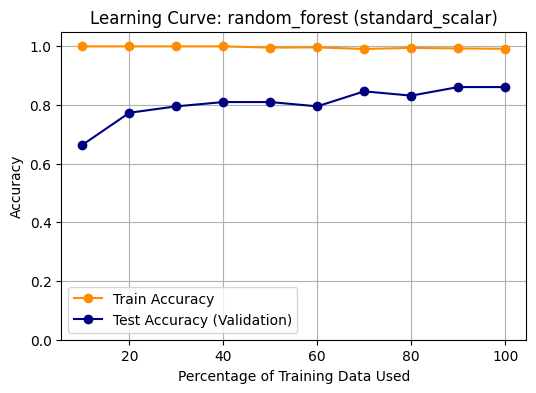

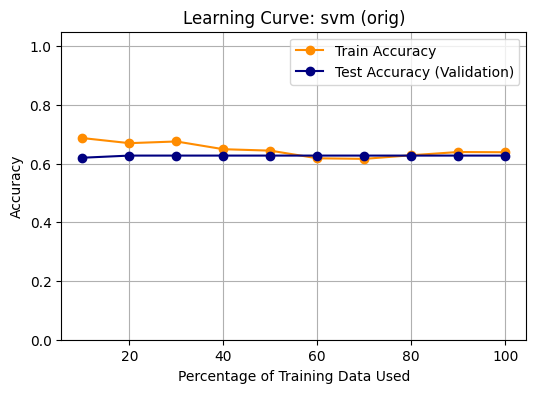

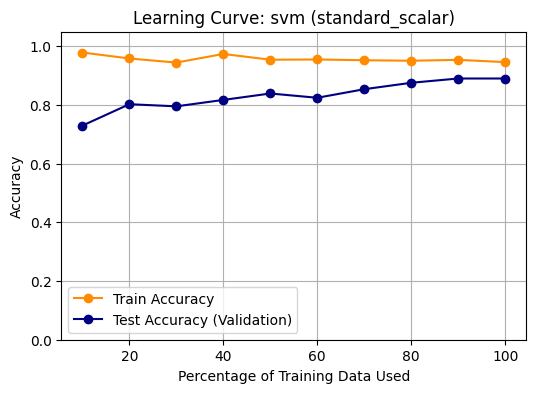

In [ ]:
# loading current data
df_curr = data_prep(file_info)

# defining Training split sizes (10% to 100% of training data)
train_fractions = np.linspace(0.1, 1.0, 10)

data_testing_full = get_train_test(df_curr, y_col=Y_COL, scaling_used=True)

def get_best_estimator(row, input_dim=None):
    """Reconstructs the model object from the best results row."""
    name = row['model used']

    # Helper to clean params (handle NaNs)
    def get_param(col, default=None, dtype=float):
        val = row.get(col)
        if pd.isna(val):
            return default
        if dtype == int:
            return int(val)
        return val

    if name == 'logistic regression':
        return LogisticRegression(
            C=get_param('logistic_reg_c', 1.0),
            l1_ratio=get_param('lr_ratios', 0.0),
            max_iter=1000
        )
    elif name == 'knn':
        return KNeighborsClassifier(
            n_neighbors=get_param('knn_n_neighbor', 5, int),
            weights=row.get('knn_weights', 'uniform')
        )
    elif name == 'decision_tree':
        return DecisionTreeClassifier(
            max_depth=get_param('dt_max_depth', None, int),
            min_samples_split=get_param('dt_min_samples_split', 2, int),
            random_state=RANDOM_STATE
        )
    elif name == 'random_forest':
        return RandomForestClassifier(
            n_estimators=get_param('rf_n_estimators', 100, int),
            max_depth=get_param('rf_max_depth', None, int),
            min_samples_leaf=get_param('rf_min_samples_leaf', 1, int),
            min_samples_split=get_param('rf_min_samples_split', 2, int),
            random_state=RANDOM_STATE
        )
    elif name == 'svm':
        return SVC(
            C=get_param('svm_c_val', 1.0),
            kernel=row.get('svm_kernel', 'rbf'),
            probability=True,
            max_iter=20000
        )
    elif name == 'gbm':
        return GradientBoostingClassifier(
            learning_rate=get_param('gbm_learning_rate', 0.1),
            n_estimators=get_param('gbm_n_estimator', 100, int),
            random_state=RANDOM_STATE
        )
    elif name == 'neural net':
        def build_nn():
            model = Sequential()
            model.add(Input(shape=(input_dim,)))
            layers = get_param('nn_layers', 1, int)
            neurons = get_param('nn_neurons', 32, int)
            for _ in range(layers):
                model.add(Dense(neurons, activation="relu"))
            model.add(Dense(1, activation="sigmoid"))
            model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
            return model
        return build_nn()
    return None

# loop through each best model and plot
for index, row in best_models.iterrows():
    model_name = row['model used']
    scalar = row['scalar_status']

    # retrieve the correct data split from the dictionary
    if scalar not in data_testing_full:
        print(f"Skipping {model_name} ({scalar}): data not available.")
        continue

    data_split = data_testing_full[scalar]
    X_train_full = data_split["X_train"]
    X_test = data_split["X_test"]
    y_train_full = data_split["y_train"]
    y_test = data_split["y_test"]

    input_dim = X_train_full.shape[1]

    # initialize estimator with input dimension for NN (checks if model can be constructed)
    estimator = get_best_estimator(row, input_dim=input_dim)
    if estimator is None:
        continue

    train_scores = []
    test_scores = []

    # iterate over subset sizes
    for frac in train_fractions:
        # determine subset size
        n_samples = int(frac * len(X_train_full))

        # slicing to get the subset
        if hasattr(X_train_full, 'iloc'):
            X_sub = X_train_full.iloc[:n_samples]
        else:
            X_sub = X_train_full[:n_samples]

        if hasattr(y_train_full, 'iloc'):
            y_sub = y_train_full.iloc[:n_samples]
        else:
            y_sub = y_train_full[:n_samples]

        # Train and Evaluate
        if model_name == 'neural net':
            bs = int(row.get('nn_batch_size', 32))
            ep = int(row.get('nn_epochs', 10))

            # rebuiling for next iteration to avoid incremental learning
            estimator = get_best_estimator(row, input_dim=input_dim)
            estimator.fit(X_sub, y_sub, epochs=ep, batch_size=bs, verbose=0)

            # making predictions
            train_pred = (estimator.predict(X_sub, verbose=0).flatten() > 0.5).astype(int)
            test_pred = (estimator.predict(X_test, verbose=0).flatten() > 0.5).astype(int)

            train_scores.append(accuracy_score(y_sub, train_pred))
            test_scores.append(accuracy_score(y_test, test_pred))

        else:
            estimator = get_best_estimator(row, input_dim=input_dim)
            estimator.fit(X_sub, y_sub)
            train_scores.append(accuracy_score(y_sub, estimator.predict(X_sub)))
            test_scores.append(accuracy_score(y_test, estimator.predict(X_test)))

    # plotting
    plt.figure(figsize=(6, 4))
    plt.plot(train_fractions * 100, train_scores, 'o-', label="Train Accuracy", color="darkorange")
    plt.plot(train_fractions * 100, test_scores, 'o-', label="Test Accuracy (Validation)", color="navy")
    plt.title(f"Learning Curve: {model_name} ({scalar})")
    plt.xlabel("Percentage of Training Data Used")
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.05)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()